**TODO**: Remove below (drive-specific)

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ln -s /content/drive/MyDrive/Didattica/OENNE_notebooks/utils .

**TODO**: Remove below (server-specific)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


## Hands-on #2: Structured Pruning with PLiNIO



In this notebook, you will:
1. Load the optimized DNN found at the end of Hands-on #1
2. Apply structured pruning with the PIT algorithm "on top" of this optimized DNN
3. Export and optionally fine-tune the pruned model.

Considering the flow seen in class, we are here:

![pruning.png]()

# Part 0: Initial Setup

As usual, we start by importing required libraries:

In [3]:
import os
import sys
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchinfo import summary

from plinio.cost import params
from plinio.methods import PIT

import pytorch_benchmarks.image_classification as icl
from pytorch_benchmarks.utils import CheckPoint, EarlyStopping

from utils.train import set_seed, try_load_checkpoint
from utils.plot import plot_learning_curves

And repeat the initial configurations:

In [4]:
SAVE_DIR = Path(f"experiments/02/")

TRAINING_CONFIG = {
    'in_class': False,          # kept for compatibility with hands-on #1. Leave it as false!
    'epochs': 50,               # max epochs for normal trainings
    'nas_epochs': 400,          # max epochs for the NAS search loop
    'nas_no_stop_epochs': 400,  # initial epochs without early stopping for the NAS
    'batch_size': 32,           # batch size
    'lr': 0.1,                  # initial learning rate for normal trainings
    'search_lr_net': 0.001,     # learning rate for DNN weights during NAS
    'search_lr_nas': 0.001,     # learning rate for NAS parameters during NAS
    'weight_decay': 1e-4,       # weight decay for normal DNN parameters
    'patience': 10,             # early-stopping patience for normal trainings
    'nas_patience': 25,         # early-stopping patience for NAS search
}

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

Working on: cuda:0


# Part 1: Dataset Preparation

Dataset preparation is identical to the previous notebook:

In [5]:
datasets = icl.get_data()
dataloaders = icl.build_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
train_dl, val_dl, test_dl = dataloaders

input_shape = datasets[0][0][0].numpy().shape
batch_shape = (1,) + input_shape

Files already downloaded and verified
Files already downloaded and verified


For the following parts of this notebook, we will use an open-source DNN optimization library called **PLiNIO** (Plug-and Play Lightweight Neural Inference Optimization), that we developed internally at Politecnico di Torino. You can find PLiNIO's code and documentation at [this](https://github.com/eml-eda/plinio) link.

![plinio.png]( 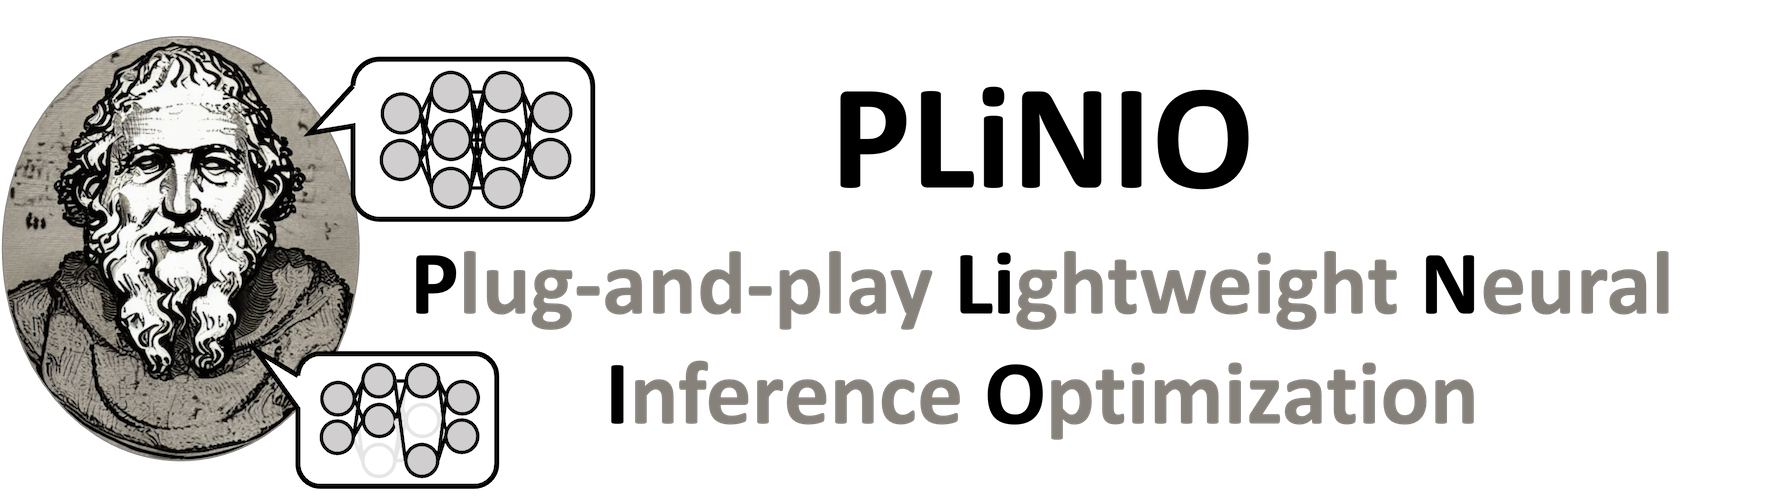)

Of course, there are many alternatives to this library, some much more complete and capable. Examples include Microsoft's [NNI](https://github.com/microsoft/nni) or Freiburg's [NASLib](https://github.com/automl/NASLib). We use PLiNIO for the following reasons:
- It was designed with usability in mind, and requires miminal modifications to your existing pytorch training code, which is good for time-constrained sessions like ours.
- As we will see later, PLiNIO can export ONNX files in the format expected by our DNN compiler (MATCH) and target hardware (GAP9).
- We developed the library internally, so we should be able to solve issues if they occur (hopefully....)

As you can read in the documentation, PLiNIO supports multiple types of optimization, with a common API. In general, optimizing a model with PLiNIO requires three basic steps.

- Converting a PyTorch model (an `nn.Module` instance), possibly including some "special layers" and optionally pre-trained, to an optimizable format
- Training the converted model, with a modified loss function that considers both the model's accuracy and its cost (e.g. in terms of number of parameters).
- Exporting the final output of the optimization again as a standard pytorch `nn.Module`


# Part 3: Structured Pruning with PIT

In Hands-on #1, we found DNN architectures that obtain good accuracy vs model size trade-offs for CIFAR 10 (within our limited search space). Now, we want to further reduce the size of one of these models, applying structured pruning with the PIT algorithm to eliminate some of the least important channels from each layer.

## The PIT Algorithm

PIT is essentially a channel-based pruning algorithm, and is described in details [here](https://arxiv.org/abs/2301.10281). During training, it learns to mask out unimportant channels for each layer, effectively eliminating them from the network. The working principle is schematized in the following picture:

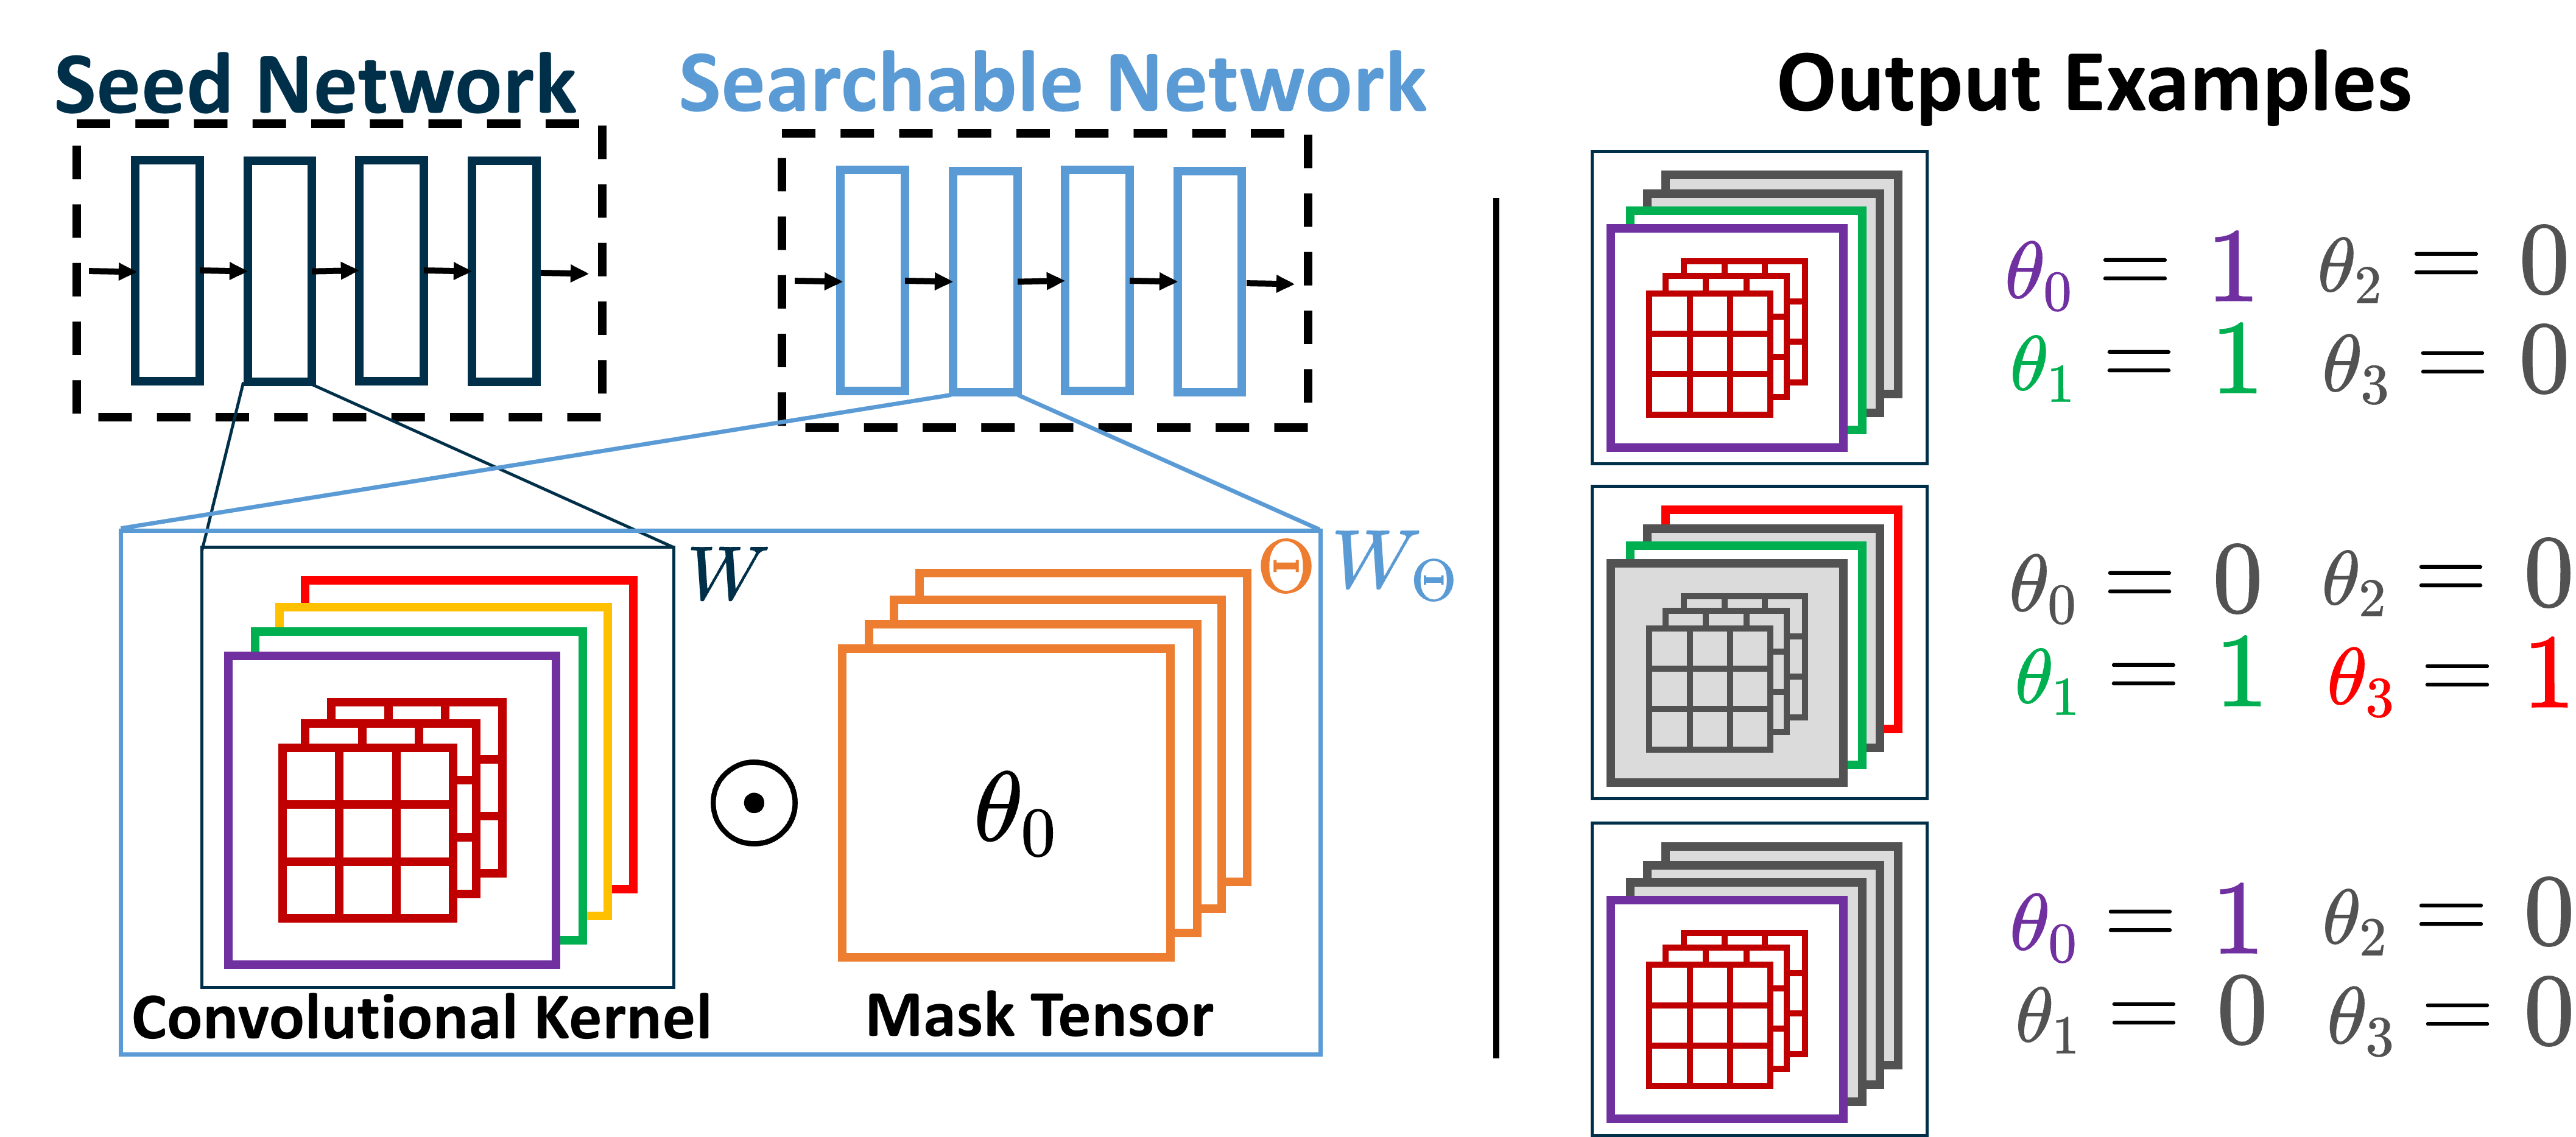

The "seed" DNN (a standard network) is turned into a "searchable" DNN by associating each supported layer (convolutional or linear) with a new set of trainable *binary* parameters $\theta$. Each $\theta_i$ is associated with a single weight filter/neuron, and functions as a mask. When it is set to $\theta_i=1$, the filter/neuron is kept, whereas, when it is set to $\theta_i =0 $ it is removed from the layer's output. Thus, the corresponding output activation channel is effectively eliminated. Notably, PIT can also optimize other parameters of 1D Convolutions (namely the kernel size and the dilation).

The $\theta$ values are trained with gradient-descent together with the normal weights of the network. In practice, what is actually trained are continuous parameters $\alpha$, from which $\theta$ binary masks are obtained through a step function ($\theta_i = \mathcal{H}(\alpha_i)$). Similarly to a SuperNet DNAS, the goal is to optimize a combined loss function in the form:

$$
\mathcal{L}_{tot}(W,\theta) = \mathcal{L}_{task}(W,\theta) + \lambda \mathcal{L}_{cost}(\theta)
$$

where $\mathcal{L}_{task}$ is the standard task-loss (cross-entropy in our case), while $\mathcal{L}_{cost}$ encodes the cost of the network. In fact, although PIT essentially implements channel pruning, it can also be considered a form of "mask-based DNAS". In the following, we will use model size (n. of parameters) as cost metric. 

## Importing the Model

Let's start by loading the final model from Hands-on #1:

In [6]:
MODEL_PATH = Path("./experiments/01/final_model.pt")
model = torch.load(MODEL_PATH).eval()

Quickly verify that it's correctly loaded:

In [7]:
criterion = nn.CrossEntropyLoss()
test_metrics = icl.evaluate(model, criterion, test_dl, device)
size = summary(model, batch_shape).total_params
print(f'Size: {size}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Size: 71258, Test Loss: 0.5582961440086365, Test Acc: 81.04000091552734


## Preparing the Model

For the PIT algorithm, PLiNIO makes the optimization process much more transparent than for the SuperNet case. In fact, for the SuperNet, we had to manually define a multi-path DNN with multiple layer alternatives. In this case, instead, the input is a standard DNN (in our case, the optimized one from Hands-on #1). To make this model "optimizable", it suffices to pass it to the `PIT` class constructor from PLiNIO. The constructor internally implements the conversion steps necessary to generate the "searchable" network sketched in the figure above, replacing all Conv. and Linear layers with the respective mask-equipped versions, and handling all the necessary shape propagations to correctly estimate the DNN cost.

The parameters of the constructor are the same of SuperNet, with the addition of the optional `discrete_cost=True`, which ensures that cost is estimated using the discretized version of the masks (i.e. $\theta$, rather than $\alpha$).



### Getting an Initial Cost Estimate 

Let's call the constructor and get the initial cost estimate.

In [8]:
nas_model = PIT(model, input_shape=input_shape, cost=params, discrete_cost=True)
nas_model = nas_model.to(device)
print(f"Estimated DNN cost: {nas_model.cost}")

Estimated DNN cost: 70186.0


Once again, you should have a cost that is *slightly lower* than the one computed by `torchinfo`. The reason is different from the SuperNet case: here, the reduction comes from the fact that, during the conversion implemented by the PIT constructor, Batch Normalization layers are folded with convolutions (as seen in class). This is necessary for the optimization to work.

### Looking at the Pruning Masks

Similarly to the SuperNet, we can look at the initial values of the PIT pruning masks:

In [9]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

**Question**: Is the number of mask values expected? Why?

### Setting the Regularization Strength

Identically to the SuperNet case, we have to set the value of $\lambda$ for our combined loss function. Note that PIT generally requires *lower strength* values. However, as mentioned before, there isn't a golden rule here, unfortunately. Some trial and error is required (or a more advanced regulatization method such as [DUCCIO](https://ieeexplore.ieee.org/abstract/document/10278089). As a suggestion, try values $\le 10^{-6}$.


In [10]:
TRAINING_CONFIG['reg_strength'] = 0 # (result around 83% acc - after fine-tuning, and 70k params - almost no pruning)
#TRAINING_CONFIG['reg_strength'] = 1e-06

## Run the NAS Loop

For running the NAS optimization, we can reuse entirely the code seen in Hands-on #1. Thanks to the `ipynb` Python package, we can load definitions (classes, functions, etc) defined in another Jupyter notebook. Let's use it to load our NAS loop from Hands-on #1. Thanks to the transparent API of PLiNIO, this code, initially written for a SuperNet optimization, will work fine also for PIT. Clearly, to obtain optimal results, one would need to tweak with the parameters, which in some cases could require some code rewriting. However, for this basic example, reusing 100\% of the NAS loop will suffice.

The next cell runs the optimization:

In [ ]:
from ipynb.fs.defs.I_SuperNet import nas_loop

criterion = nn.CrossEntropyLoss()
history = nas_loop(SAVE_DIR / 'nas', TRAINING_CONFIG, nas_model, criterion, train_dl, val_dl, device)

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.21batch/s, loss=0.661, acc=77, val_loss=0.651, val_acc=77.7]


Network cost after epoch 1 = 70186.0


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 103.40batch/s, loss=0.613, acc=78.5, val_loss=0.604, val_acc=79.2]


Network cost after epoch 2 = 70186.0


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 89.37batch/s, loss=0.629, acc=78.3, val_loss=0.62, val_acc=78.8]


Network cost after epoch 3 = 70186.0


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.84batch/s, loss=0.607, acc=78.7, val_loss=0.595, val_acc=79]


Network cost after epoch 4 = 70186.0


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 88.76batch/s, loss=0.6, acc=79.2, val_loss=0.606, val_acc=79.1]


Network cost after epoch 5 = 70186.0


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.57batch/s, loss=0.611, acc=78.9, val_loss=0.613, val_acc=78.9]


Network cost after epoch 6 = 70186.0


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.97batch/s, loss=0.597, acc=79.3, val_loss=0.603, val_acc=78.9]


Network cost after epoch 7 = 70186.0


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 103.75batch/s, loss=0.613, acc=78.3, val_loss=0.612, val_acc=78.9]


Network cost after epoch 8 = 70186.0


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.43batch/s, loss=0.594, acc=79.1, val_loss=0.598, val_acc=79]


Network cost after epoch 9 = 70186.0


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.52batch/s, loss=0.615, acc=79.2, val_loss=0.6, val_acc=78.9]


Network cost after epoch 10 = 70186.0


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.17batch/s, loss=0.586, acc=79.2, val_loss=0.595, val_acc=79]


Network cost after epoch 11 = 70186.0


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.07batch/s, loss=0.603, acc=79, val_loss=0.594, val_acc=79.5]


Network cost after epoch 12 = 70186.0


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.83batch/s, loss=0.59, acc=79.5, val_loss=0.601, val_acc=78.8]


Network cost after epoch 13 = 70186.0


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.00batch/s, loss=0.607, acc=79, val_loss=0.609, val_acc=78.9]


Network cost after epoch 14 = 70186.0


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.71batch/s, loss=0.617, acc=78.4, val_loss=0.624, val_acc=78.1]


Network cost after epoch 15 = 70186.0


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.82batch/s, loss=0.6, acc=79, val_loss=0.6, val_acc=78.9]


Network cost after epoch 16 = 70186.0


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.29batch/s, loss=0.617, acc=78.7, val_loss=0.615, val_acc=78.7]


Network cost after epoch 17 = 70186.0


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 103.94batch/s, loss=0.583, acc=79.7, val_loss=0.589, val_acc=79.7]


Network cost after epoch 18 = 70186.0


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.64batch/s, loss=0.593, acc=79.4, val_loss=0.594, val_acc=79.5]


Network cost after epoch 19 = 70186.0


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.13batch/s, loss=0.594, acc=79.6, val_loss=0.605, val_acc=79.3]


Network cost after epoch 20 = 70186.0


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 102.47batch/s, loss=0.584, acc=79.5, val_loss=0.599, val_acc=78.8]


Network cost after epoch 21 = 70186.0


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.29batch/s, loss=0.588, acc=79.2, val_loss=0.59, val_acc=79.9]


Network cost after epoch 22 = 70186.0


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.88batch/s, loss=0.608, acc=78.9, val_loss=0.616, val_acc=78.9]


Network cost after epoch 23 = 70186.0


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.73batch/s, loss=0.591, acc=79.5, val_loss=0.592, val_acc=79.6]


Network cost after epoch 24 = 70186.0


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.13batch/s, loss=0.594, acc=79.1, val_loss=0.603, val_acc=79]


Network cost after epoch 25 = 70186.0


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.38batch/s, loss=0.603, acc=79.1, val_loss=0.601, val_acc=79.1]


Network cost after epoch 26 = 70186.0


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.14batch/s, loss=0.592, acc=79.3, val_loss=0.591, val_acc=79.5]


Network cost after epoch 27 = 70186.0


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.31batch/s, loss=0.598, acc=79.2, val_loss=0.606, val_acc=79]


Network cost after epoch 28 = 70186.0


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.54batch/s, loss=0.589, acc=79.6, val_loss=0.584, val_acc=79.4]


Network cost after epoch 29 = 70186.0


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.65batch/s, loss=0.598, acc=79.2, val_loss=0.584, val_acc=79.7]


Network cost after epoch 30 = 70186.0


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.80batch/s, loss=0.596, acc=79.2, val_loss=0.594, val_acc=79.5]


Network cost after epoch 31 = 70186.0


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.18batch/s, loss=0.593, acc=79, val_loss=0.581, val_acc=79.7]


Network cost after epoch 32 = 70186.0


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.92batch/s, loss=0.594, acc=79.4, val_loss=0.599, val_acc=79.4]


Network cost after epoch 33 = 70186.0


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.34batch/s, loss=0.593, acc=79.6, val_loss=0.592, val_acc=79.4]


Network cost after epoch 34 = 70186.0


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.63batch/s, loss=0.59, acc=79.1, val_loss=0.579, val_acc=79.7]


Network cost after epoch 35 = 70186.0


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.38batch/s, loss=0.613, acc=78.7, val_loss=0.622, val_acc=78.5]


Network cost after epoch 36 = 70186.0


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.92batch/s, loss=0.6, acc=79.3, val_loss=0.592, val_acc=79.5]


Network cost after epoch 37 = 70186.0


Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.78batch/s, loss=0.587, acc=79.5, val_loss=0.581, val_acc=79.2]


Network cost after epoch 38 = 70186.0


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.52batch/s, loss=0.582, acc=80, val_loss=0.586, val_acc=79.6]


Network cost after epoch 39 = 70186.0


Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 104.27batch/s, loss=0.606, acc=79.1, val_loss=0.598, val_acc=79.6]


Network cost after epoch 40 = 70186.0


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.98batch/s, loss=0.605, acc=79.1, val_loss=0.607, val_acc=79.1]


Network cost after epoch 41 = 70186.0


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.19batch/s, loss=0.58, acc=80.1, val_loss=0.586, val_acc=79.8]


Network cost after epoch 42 = 70186.0


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.49batch/s, loss=0.584, acc=79.9, val_loss=0.59, val_acc=79.3]


Network cost after epoch 43 = 70186.0


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 104.21batch/s, loss=0.589, acc=79.5, val_loss=0.59, val_acc=79.5]


Network cost after epoch 44 = 70186.0


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.83batch/s, loss=0.587, acc=79.7, val_loss=0.59, val_acc=79.2]


Network cost after epoch 45 = 70186.0


Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.58batch/s, loss=0.597, acc=79.6, val_loss=0.596, val_acc=79.4]


Network cost after epoch 46 = 70186.0


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.47batch/s, loss=0.597, acc=79.5, val_loss=0.59, val_acc=79.7]


Network cost after epoch 47 = 70186.0


Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.86batch/s, loss=0.584, acc=79.9, val_loss=0.593, val_acc=79.2]


Network cost after epoch 48 = 70186.0


Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.41batch/s, loss=0.604, acc=79.2, val_loss=0.609, val_acc=79.1]


Network cost after epoch 49 = 70186.0


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.48batch/s, loss=0.606, acc=79, val_loss=0.593, val_acc=79.6]


Network cost after epoch 50 = 70186.0


Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.83batch/s, loss=0.603, acc=78.9, val_loss=0.607, val_acc=79.3]


Network cost after epoch 51 = 70186.0


Epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.66batch/s, loss=0.596, acc=79.2, val_loss=0.613, val_acc=79.2]


Network cost after epoch 52 = 70186.0


Epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.37batch/s, loss=0.605, acc=79.1, val_loss=0.589, val_acc=79.5]


Network cost after epoch 53 = 70186.0


Epoch 54: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.50batch/s, loss=0.584, acc=79.6, val_loss=0.589, val_acc=79.2]


Network cost after epoch 54 = 70186.0


Epoch 55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.84batch/s, loss=0.574, acc=80, val_loss=0.574, val_acc=80]


Network cost after epoch 55 = 70186.0


Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 109.02batch/s, loss=0.599, acc=79, val_loss=0.6, val_acc=79.1]


Network cost after epoch 56 = 70186.0


Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.49batch/s, loss=0.593, acc=79.5, val_loss=0.582, val_acc=79.7]


Network cost after epoch 57 = 70186.0


Epoch 58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.53batch/s, loss=0.597, acc=79.5, val_loss=0.599, val_acc=79.7]


Network cost after epoch 58 = 70186.0


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.24batch/s, loss=0.58, acc=79.7, val_loss=0.584, val_acc=80]


Network cost after epoch 59 = 70186.0


Epoch 60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 103.41batch/s, loss=0.607, acc=78.7, val_loss=0.598, val_acc=79.5]


Network cost after epoch 60 = 70186.0


Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.84batch/s, loss=0.582, acc=79.9, val_loss=0.598, val_acc=79.2]


Network cost after epoch 61 = 69759.0


Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 104.58batch/s, loss=0.6, acc=79.3, val_loss=0.603, val_acc=78.9]


Network cost after epoch 62 = 69759.0


Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.86batch/s, loss=0.588, acc=79.3, val_loss=0.582, val_acc=79.7]


Network cost after epoch 63 = 69759.0


Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.14batch/s, loss=0.604, acc=79.5, val_loss=0.594, val_acc=79.4]


Network cost after epoch 64 = 69759.0


Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 106.52batch/s, loss=0.598, acc=79.1, val_loss=0.594, val_acc=78.8]


Network cost after epoch 65 = 69759.0


Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.02batch/s, loss=0.601, acc=79.4, val_loss=0.591, val_acc=79.7]


Network cost after epoch 66 = 69759.0


Epoch 67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 101.05batch/s, loss=0.598, acc=79.6, val_loss=0.587, val_acc=79.8]


Network cost after epoch 67 = 69759.0


Epoch 68:  56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 703/1250 [00:02<00:01, 292.28batch/s, loss=0.46072, acc=83.95]

### Evaluating the Pruned Model

Let's check the test accuracy of the pruned DNN after applying PIT.

In [ ]:
test_metrics = icl.evaluate(nas_model, criterion, test_dl, device)
print(f'Final model cost: {nas_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Depending on the regularization strength that you set, you should see that the cost (number of parameters) has reduced significantly once again, possibly at the cost of some accuracy degradation.

### Looking at the Masks (After the Search)

**Question:** Let's look again at the $\theta$ parameters. Have they changed? How? Which layers have been pruned the most? Is there one layer that *hasn't* been pruned at all? Which one and why?


In [ ]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

## Final Model Export (and Fine-Tuning)

As for the SuperNet, we can use the `model.export()` method to obtain a standard `nn.Module` after the optimization implemented by PIT:

In [ ]:
nas_model.train_net_and_nas()
final_model = nas_model.export()
final_model = final_model.to(device)

Let's look at the architecture of the optimized model using `torchinfo`.

In [ ]:
print(summary(final_model, batch_shape, depth=5))

**Question**: Look at the exported model summary. Does the number of channels in each layer match with the mask values printed above?


In case of the PIT algorithm, fine-tuning the exported model for some epochs is *more important* than for the SuperNet. This is because, in the same way that PIT *folds* BatchNorm layers before the search, it *unfolds* them during the export. This ensures that the final model has the same architecture of the original one.

You can verify this by testing the model just after export. You will see the accuracy drop significantly. However, few epochs of fine-tuning should suffice to recover the drop, and possibly even improve the final accuracy (thanks to BatchNorm). Let's run them.

In [ ]:
from ipynb.fs.defs.I_SuperNet import training_loop

criterion = nn.CrossEntropyLoss()
history = training_loop(SAVE_DIR / 'finetune', TRAINING_CONFIG, final_model, criterion, train_dl, val_dl, device)

Finally, let's evaluate our optimized model on the test set:

In [ ]:
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

**Question:** Considering SuperNet and PIT combined, by how much did you manage to compress the model size? At what cost in terms of accuracy?

## Saving the Final Model

Let's save the model in a separate location to reuse it more easily in later sessions:

In [ ]:
torch.save(final_model, SAVE_DIR / f'final_model.pt')